In [16]:
# Importing all the necessary libraries
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from Multimodal_baseline_Functions import *
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
# import keras_metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3

In [17]:
# Storing directory of glove embeddings
GLOVE_DIR = "C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\glove.6B"
EMBEDDING_DIM = 50

In [18]:
# Assigning class weights
class_weight = {1: 1.4,
                0: 1.}

In [19]:
# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

In [20]:
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)
    return x

In [21]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [22]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [23]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [24]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [25]:
# Creating train, test, val, generator for meme (gives -> {image,text in image, O/NO} )
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text (gives -> {text in image, O/NO})
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image (gives -> {image, O/NO})
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [26]:
# Creating vocabulary with glove embeddings
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [27]:
# Creating word index
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [28]:
#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

In [16]:
# Defining input layer
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# Defining embedding layer which will encode the input sequence
embedded_sequences = embedding_layer(main_input)

In [ ]:


# # A LSTM will transform the vector sequence into a single vector,
# # containing information about the entire sequence
# lstm1 = LSTM(32, return_state=True)
# encoder_outputs,state_h,state_c = (lstm1)(embedded_sequences)
# states= [state_h,state_c]

W1109 01:05:03.298506  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 01:05:03.305695  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1109 01:05:03.348326  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1109 01:05:03.350874  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [ ]:
# # Defining second LSTM
# lstm2=LSTM(32, return_sequences=True, return_state=True)
# # Adding initial state as state of  previous LSTM
# decoder_out,_,_=lstm2(embedded_sequences,initial_state=states)
# # Adding dense layer with 500 neurons
# decoder_dense = (Dense(500, activation='relu'))
# # LSTM output
# lstm_out=(decoder_out)
# # Flattening 
# lstm_out = Flatten()(lstm_out)
# # Output of text model
# txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [17]:
# # Defining text model
# txt_model = Model(inputs = [main_input], outputs=txt_out)

NameError: name 'txt_out' is not defined

In [30]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, GlobalAveragePooling2D, Embedding, concatenate
from keras.applications import ResNet50
from keras.layers import Embedding

In [12]:
# Image Input and CNN
image_input = Input(shape=(224, 224, 3), name='image_input')
base_cnn = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
cnn_out = GlobalAveragePooling2D()(base_cnn.output)
cnn_out = Dense(128, activation='relu')(cnn_out)
img_prediction_layer = Dense(1, activation='sigmoid')(cnn_out)
# pre_trained_image_model = VGG16(weights='imagenet', include_top=False)
img_model = Model(inputs = [base_cnn.input], outputs=img_prediction_layer)
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])


W1127 13:36:22.085921 12592 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1127 13:36:22.102040 12592 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1127 13:36:22.131048 12592 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1127 13:36:22.132048 12592 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is de

In [13]:
img_model.fit_generator(img_gen_train,
                        epochs=7,
                        validation_steps = len(x_val)//32,
                        steps_per_epoch=len(x_train)//32, 
                        validation_data=img_gen_val, 
                        shuffle=False, 
                        class_weight=class_weight)

Epoch 1/7
13/13 [==============================] - 255s 20s/step - loss: 0.1758 - acc: 0.9495 - val_loss: 0.0613 - val_acc: 1.0000
Epoch 2/7
13/13 [==============================] - 242s 19s/step - loss: 9.1386e-04 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/7
13/13 [==============================] - 235s 18s/step - loss: 3.2752e-05 - acc: 1.0000 - val_loss: 9.5367e-07 - val_acc: 1.0000
Epoch 4/7
13/13 [==============================] - 243s 19s/step - loss: 7.9087e-06 - acc: 1.0000 - val_loss: 4.7504e-04 - val_acc: 1.0000
Epoch 5/7
13/13 [==============================] - 232s 18s/step - loss: 3.7491e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 6/7
13/13 [==============================] - 233s 18s/step - loss: 2.3595e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 7/7
13/13 [==============================] - 238s 18s/step - loss: 1.7808e-06 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000


In [14]:
img_model.save('image_model_1.00ac.h5')

In [31]:
from keras.models import load_model

# Load the model into the img_model variable
img_model = load_model('image_model_1.00ac.h5')

In [34]:
# # Text Input and LSTM
# text_input = Input(shape=(maxlen,), dtype='int32', name='text_input')
# embedded_text = embedding_layer(text_input)
# lstm_out = LSTM(32)(embedded_text)/

from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, Embedding
from keras.layers import Activation, Dot
from keras.models import Model

# Text Input
text_input = Input(shape=(maxlen,), dtype='int32', name='text_input')

# Embedding Layer (using pre-trained GloVe embeddings)
embedded_text = embedding_layer(text_input)

# Bidirectional LSTM Layer
lstm_out = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedded_text)

# Attention Mechanism
attention = Dense(1, activation='tanh')(lstm_out)
attention = Flatten()(attention)
attention_weights = Activation('softmax')(attention)
context_vector = Dot(axes=1)([lstm_out, attention_weights])

# Fully Connected Layer with Batch Normalization
dense_out = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(context_vector)
dense_out = Dropout(0.3)(dense_out)

# Final Output Layer
output = Dense(1, activation='sigmoid')(dense_out)

# Define the Model
text_model = Model(inputs=text_input, outputs=output)

# Compile the Model
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_model.summary()


W1127 19:23:33.542382 12592 deprecation.py:506] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 50)     219000      text_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 1000, 128)    58880       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000, 1)      129         bidirectional_1[0][0]            
__________________________________________________________________________________________________
flatten_1 

In [35]:
# Training text model
text_model.fit_generator(txt_gen_train, 
                         epochs=7, 
                         validation_steps = len(x_val)//32, 
                         steps_per_epoch=len(x_train)//32, 
                         validation_data=txt_gen_val, 
                         shuffle = False, 
                         class_weight=class_weight)

Epoch 1/7
13/13 [==============================] - 13s 968ms/step - loss: 1.9190 - acc: 0.5168 - val_loss: 1.6554 - val_acc: 0.5000
Epoch 2/7
13/13 [==============================] - 9s 681ms/step - loss: 1.6520 - acc: 0.5962 - val_loss: 1.4093 - val_acc: 0.7500
Epoch 3/7
13/13 [==============================] - 9s 707ms/step - loss: 1.4400 - acc: 0.5986 - val_loss: 1.2347 - val_acc: 0.5000
Epoch 4/7
13/13 [==============================] - 9s 728ms/step - loss: 1.2775 - acc: 0.5986 - val_loss: 1.0947 - val_acc: 0.5000
Epoch 5/7
13/13 [==============================] - 10s 737ms/step - loss: 1.1525 - acc: 0.5986 - val_loss: 0.9717 - val_acc: 0.7500
Epoch 6/7
13/13 [==============================] - 10s 754ms/step - loss: 1.0590 - acc: 0.5913 - val_loss: 0.9052 - val_acc: 0.5000
Epoch 7/7
13/13 [==============================] - 10s 765ms/step - loss: 0.9887 - acc: 0.5962 - val_loss: 0.8356 - val_acc: 0.7500


In [ ]:
con_layer = concatenate([text_model.output, img_model.output])
dense = Dense(64, activation='relu')(con_layer)
dropout = Dropout(0.3)(dense)
out = Dense(1, activation='sigmoid')(dropout)
com_model = Model(inputs = [img_model.input, text_model.input], outputs=out)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [37]:
# Training
com_model.fit_generator(
    img_txt_gen_train,
    validation_data=img_txt_gen_val,
    steps_per_epoch=len(x_train)//32,
    validation_steps=len(x_val)//32,
    epochs=7,
    class_weight=class_weight
)

Epoch 1/7
13/13 [==============================] - 328s 25s/step - loss: 0.9377 - acc: 0.5361 - val_loss: 0.6251 - val_acc: 1.0000
Epoch 2/7
13/13 [==============================] - 333s 26s/step - loss: 0.8675 - acc: 0.5553 - val_loss: 0.6777 - val_acc: 0.7500
Epoch 3/7
13/13 [==============================] - 338s 26s/step - loss: 0.8409 - acc: 0.5649 - val_loss: 0.7376 - val_acc: 0.5000
Epoch 4/7
13/13 [==============================] - 348s 27s/step - loss: 0.8116 - acc: 0.5529 - val_loss: 0.5791 - val_acc: 1.0000
Epoch 5/7
13/13 [==============================] - 347s 27s/step - loss: 0.8089 - acc: 0.5385 - val_loss: 0.6984 - val_acc: 0.5000
Epoch 6/7
13/13 [==============================] - 346s 27s/step - loss: 0.7826 - acc: 0.6034 - val_loss: 0.7725 - val_acc: 0.2500
Epoch 7/7
13/13 [==============================] - 349s 27s/step - loss: 0.7920 - acc: 0.5865 - val_loss: 0.5580 - val_acc: 1.0000


In [38]:
com_model.save('newfinal_model_ac.h5')

In [ ]:
# # Fusion
# concat = concatenate([cnn_out, lstm_out])
# dense = Dense(64, activation='relu')(concat)
# dropout = Dropout(0.3)(dense)
# output = Dense(1, activation='sigmoid')(dropout)


W1126 22:47:14.102974 32732 deprecation.py:506] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# # Model
# multi_model = Model(inputs=[image_input, text_input], outputs=output)
# multi_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


W1126 22:47:25.526576 32732 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1126 22:47:25.534574 32732 deprecation.py:323] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
# Training
multi_model.fit_generator(
    img_txt_gen_train,
    validation_data=img_txt_gen_val,
    steps_per_epoch=len(x_train)//32,
    validation_steps=len(x_val)//32,
    epochs=7,
    class_weight=class_weight
)

Epoch 1/7
13/13 [==============================] - 253s 19s/step - loss: 1.0125 - acc: 0.6298 - val_loss: 4.6548 - val_acc: 0.5000
Epoch 2/7
13/13 [==============================] - 242s 19s/step - loss: 0.9472 - acc: 0.6202 - val_loss: 0.7432 - val_acc: 0.2500
Epoch 3/7
13/13 [==============================] - 239s 18s/step - loss: 1.0405 - acc: 0.6058 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 4/7
13/13 [==============================] - 254s 20s/step - loss: 0.8717 - acc: 0.5264 - val_loss: 4.5536 - val_acc: 0.2500
Epoch 5/7
13/13 [==============================] - 236s 18s/step - loss: 0.8111 - acc: 0.6202 - val_loss: 0.8940 - val_acc: 0.2500
Epoch 6/7
13/13 [==============================] - 231s 18s/step - loss: 0.7633 - acc: 0.6418 - val_loss: 2.1085 - val_acc: 0.5000
Epoch 7/7
13/13 [==============================] - 229s 18s/step - loss: 0.8146 - acc: 0.6442 - val_loss: 0.8201 - val_acc: 0.2500


In [ ]:
# Saving text modelSS
multi_model.save('final_model_0.6442ac.h5')

In [26]:
# Predicting labels of the test set
y_pred_com = (multi_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))
# Defining true labels
y_true = y_test.values

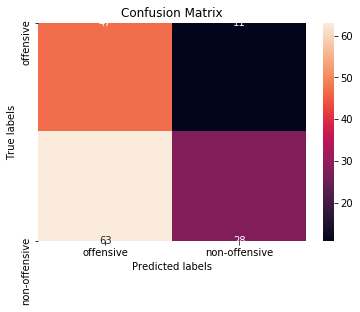

In [27]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

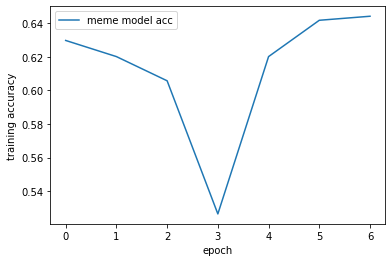

In [28]:
# Plotting training accuaracy 
plt.plot(multi_model.history.epoch, multi_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'image model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

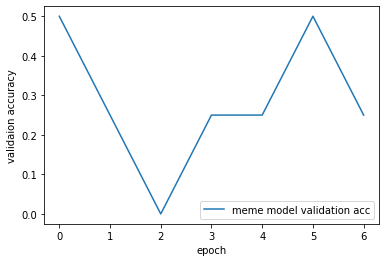

In [29]:

# Plotting validation accuracy
plt.plot(multi_model.history.epoch, multi_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'image model validation acc'))
plt.xlabel('epoch')
plt.ylabel('validaion accuracy')
plt.show()

In [30]:
# Evaluating model by calculating loss and accuracy respectively
# for combined model
multi_model.evaluate_generator(img_txt_gen_test, steps=5)

[0.7797344565391541, 0.2]

In [ ]:
# # compiling text model
# txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

W1109 01:05:09.906090  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 01:05:09.913822  5476 deprecation.py:323] From d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
# Training text model
txt_model.fit_generator(txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 19s 10s/step - loss: 0.8202 - acc: 0.4062 - val_loss: 0.7049 - val_acc: 0.4362
Epoch 2/7
2/2 [==============================] - 15s 7s/step - loss: 0.8100 - acc: 0.3750 - val_loss: 0.6913 - val_acc: 0.5436
Epoch 3/7
2/2 [==============================] - 15s 7s/step - loss: 0.7646 - acc: 0.6562 - val_loss: 0.6721 - val_acc: 0.6107
Epoch 4/7
2/2 [==============================] - 15s 7s/step - loss: 0.8411 - acc: 0.5625 - val_loss: 0.6731 - val_acc: 0.6107
Epoch 5/7
2/2 [==============================] - 15s 8s/step - loss: 0.8215 - acc: 0.5781 - val_loss: 0.6796 - val_acc: 0.6107
Epoch 6/7
2/2 [==============================] - 15s 7s/step - loss: 0.8039 - acc: 0.5781 - val_loss: 0.6876 - val_acc: 0.5973
Epoch 7/7
2/2 [==============================] - 15s 7s/step - loss: 0.8284 - acc: 0.6094 - val_loss: 0.7037 - val_acc: 0.4362


In [21]:
# Saving text model
txt_model.save('Stack_LSTM_txt_model.h5')

d:\anaconda\envs\btechproject\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [22]:
# Predicting labels of the test set
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
# Defining true labels
y_true = y_test.values

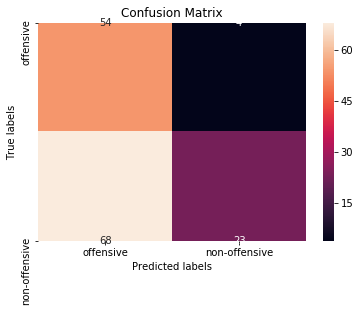

In [23]:
# Block that prints confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [24]:
# create base model with imagenet weights
pre_trained_image_model = VGG16(weights='imagenet', include_top=False)

W1109 01:07:52.340348  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [25]:
# Building img_prediction layer using Image_model
base_img = Image_model(pre_trained_image_model)
img_prediction_layer = Dense(1, activation='sigmoid')(base_img)

In [26]:
# Defining image model
img_model = Model(inputs = [pre_trained_image_model.input], outputs=img_prediction_layer)

In [ ]:
# Compiling image model
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [28]:
# Plotting image model
plot_model(img_model, to_file='VGG16_img_model.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [ ]:
# Training image model
img_model.fit_generator(img_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 33s 16s/step - loss: 2.8248 - acc: 0.5156 - val_loss: 0.1308 - val_acc: 1.0000
Epoch 2/7
2/2 [==============================] - 27s 13s/step - loss: 2.4685 - acc: 0.4688 - val_loss: 0.7130 - val_acc: 0.0000e+00
Epoch 3/7
2/2 [==============================] - 26s 13s/step - loss: 2.1571 - acc: 0.4844 - val_loss: 1.9528 - val_acc: 0.0000e+00
Epoch 4/7
2/2 [==============================] - 27s 13s/step - loss: 1.9844 - acc: 0.5156 - val_loss: 2.7603 - val_acc: 0.0000e+00
Epoch 5/7
2/2 [==============================] - 26s 13s/step - loss: 1.8334 - acc: 0.5000 - val_loss: 2.7608 - val_acc: 0.0000e+00
Epoch 6/7
2/2 [==============================] - 26s 13s/step - loss: 1.6170 - acc: 0.5000 - val_loss: 2.1896 - val_acc: 0.0000e+00
Epoch 7/7
2/2 [==============================] - 26s 13s/step - loss: 1.3790 - acc: 0.6250 - val_loss: 1.4229 - val_acc: 0.0000e+00


In [30]:
# Saving image model
img_model.save('VGG16_img_model.h5')

In [31]:
# Predicting labels using image model
y_pred_img = (img_model.predict_generator(img_gen_test,steps = 149))
y_pred_img = np.round(list(itertools.chain(*y_pred_img)))
y_true = y_test.values

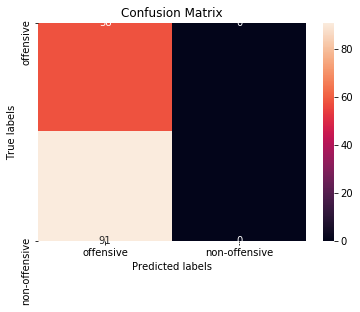

In [32]:
# Confusion matrix for image classifier
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_img, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [34]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [ ]:
# Concatenating output of both classifiers
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [36]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [37]:
# Using Stochastic gradient descent with optimizer
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [38]:
# PlotTing combined model
plot_model(com_model, to_file='Stack_LSTM_VGG_mul_model.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [39]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 39s 20s/step - loss: 0.8184 - acc: 0.4688 - val_loss: 0.7067 - val_acc: 0.3691
Epoch 2/7
2/2 [==============================] - 36s 18s/step - loss: 0.7994 - acc: 0.3594 - val_loss: 0.7007 - val_acc: 0.4228
Epoch 3/7
2/2 [==============================] - 35s 17s/step - loss: 0.7911 - acc: 0.3125 - val_loss: 0.7056 - val_acc: 0.3356
Epoch 4/7
2/2 [==============================] - 36s 18s/step - loss: 0.7923 - acc: 0.3281 - val_loss: 0.7002 - val_acc: 0.3557
Epoch 5/7
2/2 [==============================] - 35s 18s/step - loss: 0.8252 - acc: 0.4844 - val_loss: 0.6957 - val_acc: 0.4295
Epoch 6/7
2/2 [==============================] - 35s 18s/step - loss: 0.8325 - acc: 0.5469 - val_loss: 0.6962 - val_acc: 0.4295
Epoch 7/7
2/2 [==============================] - 36s 18s/step - loss: 0.8165 - acc: 0.4531 - val_loss: 0.7004 - val_acc: 0.3557


In [40]:
# Saving combined model
com_model.save('Stack_LSTM_VGG_mul_model.h5')

d:\anaconda\envs\btechproject\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [41]:
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

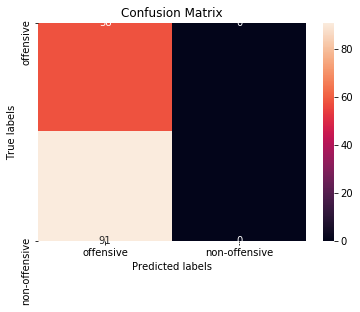

In [42]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

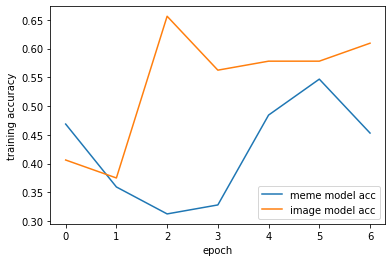

In [43]:
# Plotting training accuaracy 
plt.plot(com_model.history.epoch, com_model.history.history['acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'image model acc', 'text model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

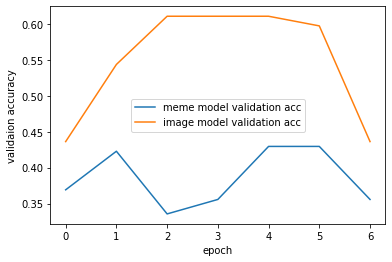

In [44]:

# Plotting validation accuracy
plt.plot(com_model.history.epoch, com_model.history.history['val_acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'image model validation acc', 'text model validation acc'))
plt.xlabel('epoch')
plt.ylabel('validaion accuracy')
plt.show()

In [46]:
# Evaluating model by calculating loss and accuracy respectively
# for combined model
com_model.evaluate_generator(img_txt_gen_test, steps=5)

[0.6794470191001892, 0.8]

In [47]:
# loss and accuracy for text model
txt_model.evaluate_generator(txt_gen_test, steps=5)

[0.6761613667011261, 0.6]

In [48]:
# Loss and accuracy for image model
img_model.evaluate_generator(img_gen_test, steps=5)

[0.023184871301054955, 1.0]

In [49]:
from sklearn.metrics import precision_recall_fscore_support

In [50]:
# for txt
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.85185185, 0.44262295]),
 array([0.25274725, 0.93103448]),
 array([0.38983051, 0.6       ]),
 array([91, 58], dtype=int64))

In [51]:
# for image
precision_recall_fscore_support(y_true, y_pred_img, beta=1.0, labels=None, pos_label=1, average=None)

d:\anaconda\envs\btechproject\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.        , 0.38926174]),
 array([0., 1.]),
 array([0.        , 0.56038647]),
 array([91, 58], dtype=int64))

In [52]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.        , 0.38926174]),
 array([0., 1.]),
 array([0.        , 0.56038647]),
 array([91, 58], dtype=int64))